In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import norm 
import time 

## Table des matières

1. [Méthodes d'approximation d'une intégrale](#part1)
    - 1.1 [Méthode du point médian](#part11)
    - 1.2 [Méthode des trapèzes](#part12)
    - 1.3 [Méthode de Simpson](#part13)
    - 1.4 [Approximation avec seuil de tolérance](#part14) 
    $$\text{}$$ 
2. [Pricing d'obligations](#part2)
    - 2.1 [Le marché des taux d'intérêts](#part21)
        - 2.1.1 [Le taux d'intérêt continu](#part211)
        - 2.1.2 [Le taux d'intérêt composé](#part212)
        - 2.1.3 [Relations entre les taux](#part213)
        - 2.1.4 [Rendement d'une obligation, taux au pair](#part214)
    - 2.2 [La duration](#part22)
    - 2.3 [La convexité](#part23)
    - 2.4 [Approximation avec seuil de tolérance](#part24)

### 1) Méthodes d'approximation d'une intégrale.<a id="part1"></a>

>**Problème:** Notre objectif dans cette section est de trouver la meilleure approximation qui soit de 
>
>$$ I := \int_a^b f(x) \, dx,$$
>
> où $f : [a,b] \rightarrow \mathbb{R}$ est une fonction intégrable. 

Dans toutes les méthodes que nous allons présenter ici, nous aurons besoin de réaliser une partition de l'intervalle $[a,b]$ en $n$ sous intervalles de même longueur, notée $h = \dfrac{b-a}{n}$ :

$$ a = a_0 < a_1 < \cdots < a_{n-1} < a_n = b.$$

Ainsi $I$ peut se ré-écrire sous la forme : 

$$ I = \sum_{i=1}^n \displaystyle \int_{a_{i-1}}^{a_i} f(x) \, dx.$$ 

> Nous prendrons en guise d'application l'intégrale $I = \displaystyle \int_0^2 \text{e}^{-x^2} \, dx$. 
>
> Notons que celle-ci peut se calculer explicitement sachant que $\displaystyle \int_{-\infty}^{+\infty}\frac{1}{\sqrt{2\pi}} \text{e}^{-\frac{x^2}{2}} \, dx = 1$. En effet en faisant le changement de variable $x = \dfrac{y}{\sqrt{2}}$ dans $I$ on obtient : 
>
> $$ I = \displaystyle \int_0^{2\sqrt{2}} \frac{1}{\sqrt{2}}\text{e}^{-\frac{y^2}{2}} \, dy = \frac{1}{\sqrt{\pi}}\left(\Phi(2\sqrt{2}) - \Phi(0)\right) \approx 0.8820813907624216.$$  

In [2]:
np.sqrt(np.pi)*(norm.cdf(2*np.sqrt(2))-norm.cdf(0))

0.8820813907624216

In [3]:
def f(x) : 
    return np.exp(-x*x) 

#### 1.1) Méthode du point médian. <a id="part11"></a>
Le principe de cette méthode est simple : on approche $f$ par une constante sur chacun des intervalles de la subdivision de sorte que sur $[a_{i-1}, a_i]$ on ait : 

$$f(x) = f\left(\dfrac{a_{i-1}+a_i}{2}\right).$$

Ainsi, 

$$ I_n^M = \sum_{i=1}^n \displaystyle \int_{a_{i-1}}^{a_i} f\left(\dfrac{a_{i-1}+a_i}{2}\right) \, dx = h\sum_{i=1}^n f\left(\dfrac{a_{i-1}+a_i}{2}\right).$$ 

In [4]:
def midpoint_rule(a,b,n,f) :
    res = 0
    h = (b-a)/n
    for i in range(1,n+1) : 
        res += f(a+(i-1/2)*h)
    return h*res 

In [5]:
midpoint_rule(0,2,100,f)

0.8820826116625586

> **Convergence de la méthode :**
Pourvu que $f''(x)$ existe et soit continue sur $[a,b]$, la méthode du point médian est convergente, de manière quadratique : 
> 
>$$|I-I_n^M| = O\left(\dfrac{1}{n^2}\right).$$
> Illustrons ce résultat : 

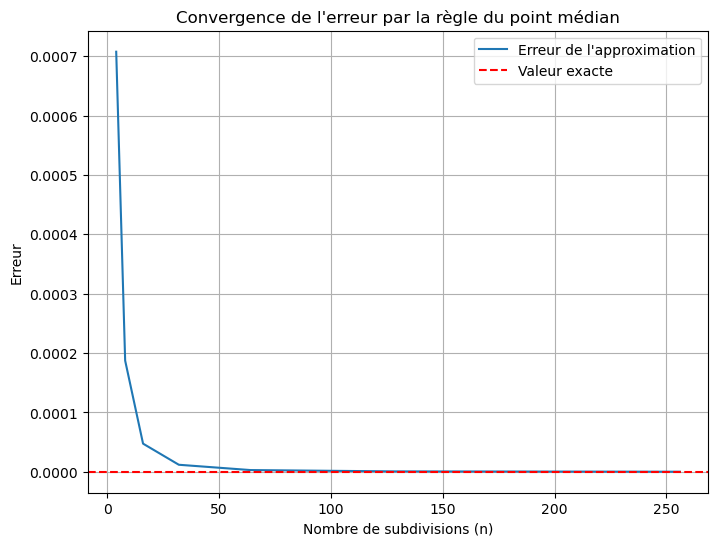

In [6]:
a = 0
b = 2
n_values = [4,8,16,32,64,128,256]
errors = []
exact_value = np.sqrt(np.pi)*(norm.cdf(2*np.sqrt(2))-norm.cdf(0))

for n in n_values:
    approximation = midpoint_rule(a, b, n, f)
    error = np.abs(approximation - exact_value)
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(n_values, errors, label='Erreur de l\'approximation')
plt.axhline(y=0, color='r', linestyle='--', label='Valeur exacte')
plt.xlabel('Nombre de subdivisions (n)')
plt.ylabel('Erreur')
plt.title('Convergence de l\'erreur par la règle du point médian')
#plt.yscale('log')  #Si une échelle logarithmique est souhaitée. 
plt.legend()
plt.grid(True)

#### 1.2) Méthode des trapèzes.  <a id="part12"></a>

La méthode des trapèzes consiste à approcher $f$ sur chaque intervalle de la subdivision par son interpolant linéaire. Autrement dit on approche $f$ sur $[a_{i-1}, a_i]$ par $l_i$ fonction linéaire telle que : 
$$\left\{
\begin{array}{l}
l_i(a_{i-1}) = f(a_{i-1}) \\
l_i(a_i) = f(a_i)
\end{array}
\right. .$$
Autrement dit, 

$$ l_i(x) = \dfrac{x-a_{i-1}}{a_i-a_{i-1}}f(a_i) + \dfrac{a_i-x}{a_i-a_{i-1}}f(a_{i-1}).$$

Ainsi, $$\displaystyle \int_{a_{i-1}}^{a_i} f(x) \, dx \approx \displaystyle \int_{a_{i-1}}^{a_i} l_i(x) \, dx = \dfrac{f(a_i)}{h} \displaystyle \int_{a_{i-1}}^{a_i} x-a_{i-1} \, dx + \dfrac{f(a_{i-1})}{h} \displaystyle \int_{a_{i-1}}^{a_i} a_i - x \, dx = \dfrac{h}{2}\left(f(a_{i-1}) + f(a_i)\right).$$ 

Finalement, 

$$  I_n^T = \sum_{i=1}^n \displaystyle \int_{a_{i-1}}^{a_i} l_i(x) \, dx = \dfrac{h}{2} \left(f(a_0) + 2\sum_{i=1}^{n-1} f(a_i) + f(a_n) \right).$$ 

In [7]:
def trapezoidal_rule(a,b,n,f) : 
    h = (b-a)/n 
    res = f(a)/2 + f(b)/2 
    for i in range(1,n) : 
        res += f(a+i*h)
    return h*res

In [8]:
trapezoidal_rule(0,2,100,f)

0.8820789488400428

> **Convergence de la méthode :**
Pourvu que $f''(x)$ existe et soit continue sur $[a,b]$, la méthode des trapèzes est convergente, de manière quadratique : 
> 
>$$|I-I_n^T| = O\left(\dfrac{1}{n^2}\right).$$
> Illustrons ce résultat : 

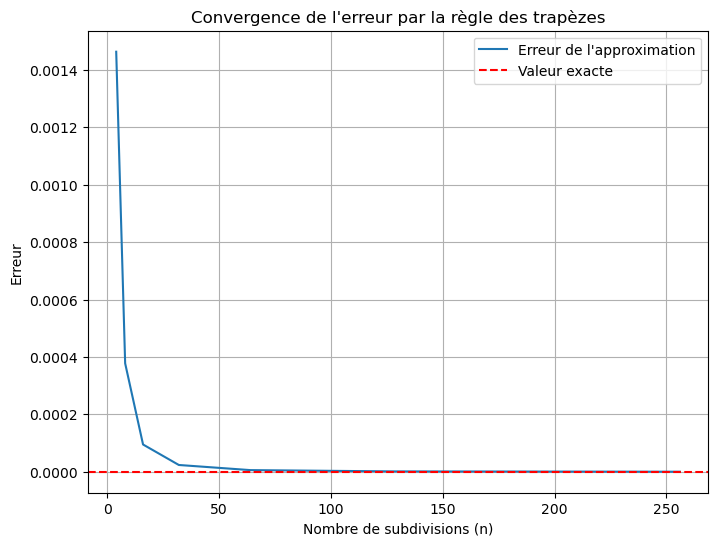

In [9]:
a = 0
b = 2
n_values = [4,8,16,32,64,128,256]
errors = []
exact_value = np.sqrt(np.pi)*(norm.cdf(2*np.sqrt(2))-norm.cdf(0))

for n in n_values:
    approximation = trapezoidal_rule(a, b, n, f)
    error = np.abs(approximation - exact_value)
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(n_values, errors, label='Erreur de l\'approximation')
plt.axhline(y=0, color='r', linestyle='--', label='Valeur exacte')
plt.xlabel('Nombre de subdivisions (n)')
plt.ylabel('Erreur')
plt.title('Convergence de l\'erreur par la règle des trapèzes')
#plt.yscale('log')  #Si une échelle logarithmique est souhaitée. 
plt.legend()
plt.grid(True)

#### 1.3) Méthode de Simpson.  <a id="part13"></a>

Nous présentons ici la méthode Simpson, qui est encore plus précise que la méthode des trapèzes, car ici nous allons utiliser une approximation de $f$ d'ordre $2$ sur chaque intervalle de la subdivision. 
Autrement dit, pour chaque intervalle, à recherche une fonction $p_i$ telle que : 

$$\left\{
\begin{array}{l}
p_i(a_{i-1}) = f(a_{i-1}) \\
p_i(a_i) = f(a_i) \\
p_i\left(\dfrac{a_{i-1}+a_i}{2}\right) = f\left(\dfrac{a_{i-1}+a_i}{2}\right)
\end{array}
\right. .$$


En utilisant l'interpolation Lagrangienne on obtient alors (en notant $x_i = \dfrac{a_{i-1}+a_i}{2}$) : 

$$p_i(x) = \dfrac{(x-a_{i-1})(x-x_i)}{(a_i - a_{i-1})(a_i - x_i)}f(a_i) + \frac{(a_i-x)(x-a_{i-1})}{(a_i -x_i)(x_i - a_{i-1})}f(x_i) + \frac{(a_i-x)(x_i-x)}{(a_i - a_{i-1})(x_i - a_{i-1})}f(a_{i-1}), \forall x \in [a_{i-1},a_i]. $$

Ainsi, $$\displaystyle \int_{a_{i-1}}^{a_i} f(x) \, dx \approx \displaystyle \int_{a_{i-1}}^{a_i} p_i(x) \, dx = \dfrac{h}{6}\left(f(a_{i-1})+4f(x_i)+f(a_{i+1})\right).$$

Finalement, 

$$  I_n^S = \sum_{i=1}^n \displaystyle \int_{a_{i-1}}^{a_i} q_i(x) \, dx = \dfrac{h}{6} \left(f(a_0) + 2\sum_{i=1}^{n-1}f(a_i) + f(a_n) + 4\sum_{i=1}^n f(x_i) \right).$$

In [10]:
def simpson_rule(a,b,n,f) : 
    h = (b-a)/n 
    res = f(a)/6 + f(b)/6
    for i in range(1,n) : 
        res += f(a+i*h)/3 
    for i in range(1,n+1) : 
        res += 2*f(a+(i-1/2)*h)/3
    return h*res 

In [11]:
simpson_rule(0,2,100,f)

0.8820813907217206

> **Convergence de la méthode :**
> L'approximation sous forme d'une parabole nécéssite une régularité plus forte de $f$. 
Pourvu que $f^{(4)}(x)$ existe et soit continue sur $[a,b]$, la méthode de Simpson est convergente, et d'ordre 4 :
> 
>$$|I-I_n^S| = O\left(\dfrac{1}{n^4}\right).$$
>
> Cela signifie que pour tout polynôme de degré $\leq 3$, la méthode de Simpson donne __exactement__ la valeur de l'intégrale. 

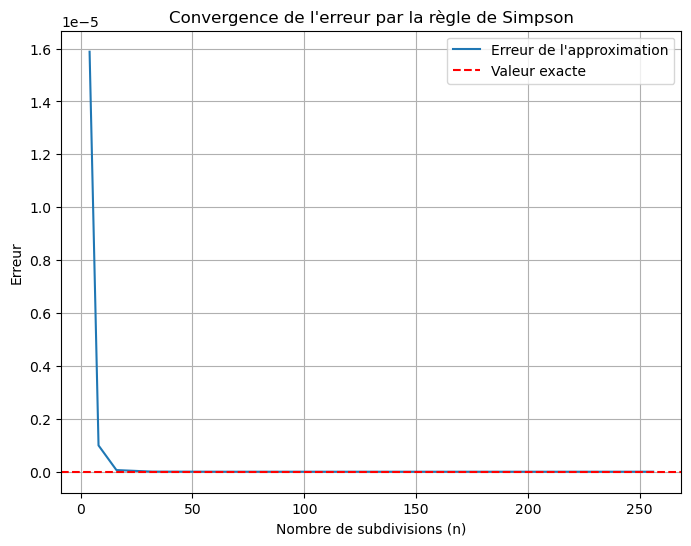

In [12]:
a = 0
b = 2
n_values = [4,8,16,32,64,128,256]
errors = []
exact_value = np.sqrt(np.pi)*(norm.cdf(2*np.sqrt(2))-norm.cdf(0))

for n in n_values:
    approximation = simpson_rule(a, b, n, f)
    error = np.abs(approximation - exact_value)
    errors.append(error)

plt.figure(figsize=(8, 6))
plt.plot(n_values, errors, label='Erreur de l\'approximation')
plt.axhline(y=0, color='r', linestyle='--', label='Valeur exacte')
plt.xlabel('Nombre de subdivisions (n)')
plt.ylabel('Erreur')
plt.title('Convergence de l\'erreur par la règle de Simpson')
#plt.yscale('log')  #Si une échelle logarithmique est souhaitée. 
plt.legend()
plt.grid(True)

> **Remarque :** Il est facile de vérifier que $I_n^S = \dfrac{2}{3}I_n^M + \dfrac{1}{3}I_n^T$.
>
> En effet : $$\dfrac{2}{3}I_n^M + \dfrac{1}{3}I_n^T = \dfrac{2h}{3} \displaystyle \sum_{i=1}^n f(x_i) + \dfrac{h}{6} \left(f(a_0) + 2\sum_{i=1}^{n-1} f(a_i) + f(a_n) \right) =  \dfrac{h}{6} \left(f(a_0) + 2\sum_{i=1}^{n-1}f(a_i) + f(a_n) + 4\sum_{i=1}^n f(x_i) \right) = I_n^S.$$
>
> Observons ce résultat dans le cadre des précédentes applications. Le résultat est bien nul (des erreurs d'arrondi subsistent) : 

In [13]:
simpson_rule(0,2,100,f)-(2/3*midpoint_rule(0,2,100,f)+1/3*trapezoidal_rule(0,2,100,f))

6.661338147750939e-16

#### 1.4) Approximation avec seuil de tolérance. <a id="part14"></a>

Il est également possible (et on le verra par la suite) qu'il soit nécéssaire d'exiger un seuil de tolérance quant à la qualité de l'approximation. Pour cela, implémentons une routine `tolerance_approximation`, permettant d'itérer (à l'aide d'une des trois méthodes précédemment introduites, sous la forme `numerical_apparox`) jusqu'à obtenir un résultat satisfaisant. 
Nous reverrons le résultat sous forme d'un tuple, le premier élement étant l'approximation `integral1`, et le second `n`, le nombre de subdivisions. 

In [14]:
def tolerance_approximation(tol, a, b, f, numerical_approx) : 
    n = 4 
    integral0 = numerical_approx(a,b,n,f)
    n *= 2 
    integral1 = numerical_approx(a,b,n,f)
    while np.abs(integral1 - integral0) > tol : 
        integral0 = integral1 
        n *= 2 
        integral1 = numerical_approx(a,b,n,f)
    return integral1,n 

In [15]:
print('Erreur comise :',np.sqrt(np.pi)*(norm.cdf(2*np.sqrt(2))-norm.cdf(0))-tolerance_approximation(1e-12, 0, 2, f, simpson_rule)[0])
print('En {} subdivisions.'.format(tolerance_approximation(1e-12, 0, 2, f, simpson_rule)[1]))

Erreur comise : 6.039613253960852e-14
En 512 subdivisions.


>**Exemple :** Soit $g : \mathbb{R^+} \rightarrow \mathbb{R}$ donnée par $g(x) = \sqrt{x}\,\text{e}^{-x}$.
> 
> Appliquons `tolerance_approximation` avec `tol = 1e-6` pour approcher $ \displaystyle \int_1^3 g(x) \,dx$.

In [16]:
def g(x) : 
    return np.sqrt(x)*np.exp(-x)

In [17]:
tolerance_approximation(1e-6, 1, 3, g, midpoint_rule)

(0.408369962144334, 256)

In [18]:
tolerance_approximation(1e-6, 1, 3, g, trapezoidal_rule)

(0.4083703896920999, 512)

In [19]:
tolerance_approximation(1e-6, 1, 3, g, simpson_rule)

(0.40837019378123046, 16)

### 2) Pricing d'obligations.<a id="part2"></a>

**Définition :** Une *obligation* est un titre de créance émis par une entreprise ou une entité gouvernementale pour emprunter de l'argent auprès d'investisseurs. En achetant une obligation, l'investisseur prête de l'argent à l'émetteur en échange de paiements d'intérêts réguliers, appelés coupons, et de la restitution du montant prêté à la date d'échéance de l'obligation. Les obligations sont généralement considérées comme des investissements à revenu fixe, car elles offrent un paiement d'intérêt prévisible sur une période déterminée, souvent assortie d'une garantie de remboursement du capital investi à l'échéance.

#### 2.1) Le marché des taux d'intérêts.  <a id="part21"></a>

#### 2.1.1) Le taux d'intérêt continu.  <a id="part211"></a>

Notons $r(0, t)$ le rendement à la date $t$ d'un dépôt en cash effectué au temps $0$, c'est le **taux zéro-coupon**. Si la cette valeur est connue pour tout $t$, la fonction continue $t \rightarrow r(0,t) $ est appelée la **courbe des taux** (*yield curve* en anglais). 

Si on note $B_0$ la valeur du deposit initial, cette dernière est régie par : 

$$B_0 = \text{e}^{-tr(0,t)}B_t \Leftrightarrow B_t = \text{e}^{tr(0,t)}B_0, $$

et la quantité $\text{e}^{-tr(0,t)}$ est le **facteur d'actualisation** (en anglais *discount factor*) correspondant au temps $t$. 

On définit également le **taux instantané** $r(t)$ au temps $t$ est le rendement d'un dépôt effectué à la date $t$, arrivant à échéance à la date $t +dt$, où $dt$ est infiniment petit. Autrement dit : 

$$ r(t) = \lim\limits_{dt \rightarrow 0} \dfrac{1}{dt} \dfrac{B_{t+dt}-B_t}{B_t} = \dfrac{B'_t}{B_t}.$$

$$ \Rightarrow  \displaystyle \int_0^t r(s) \, ds = \displaystyle \int_0^t \dfrac{B'_s}{B_s} \, ds = \ln\left(\dfrac{B_t}{B_0} \right)$$

Par identification, il vient que : 

$$ r(0,t) = \dfrac{1}{t} \displaystyle \int_0^t r(s) \, ds, $$ 

autrement dit, le taux zéro-coupon au temps $t$ est la valeur moyenne de taux instantané $r(t)$ sur l'intervalle $[0,t]$. 

Soit $B$ la valeur d'une obligation payant les flux $c_i, i=1,...,n$ aux dates $t_i, i=1,...,n$. Soit $r(0,t_i)$ le taux zéro-coupon à la date $t_i$. On obtient : 

$$ B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}\left(-r(0,t_i)t_i\right) = \displaystyle \sum_{i=1}^n c_i \, \text{exp}\left(-\displaystyle \int_0^{t_i} r(s) \, ds \right).$$

#### 2.1.2) Le taux d'intérêt composé.  <a id="part212"></a> 

Supposons que les intérêts soient composés $m$ fois dans l'année, en notant $r_m(0,t)$ la courbe zéro-coupon correspondante. Avec comme deposit initial $B_0$, ce montant au temps $t$ devient : 

$$ B_m(t) = B_0\left(1+\dfrac{r_m(0,t)}{m}\right)^{mt},$$

et le facteur d'actualisation est ici $\left(1+\dfrac{r_m(0,t)}{m}\right)^{-mt}$.

Regardons l'effet de la fréquence de composition des intérêts sur la valeur nominale (*face value* en anglais) $F = 100 €$ au bout d'un an avec un taux de $r = 0.10$, soit $10 \%$ : 

| Fréquence de composition |     Valeur de 100 € à la fin de l'année avec $r = 0.10$  | 
|--------------------------|-------------------------------------|
| Annuelle $(m=1)$         | $100\left(1+0.1\right)^1 = 110.00€$ | 
| Semestrielle $(m=2)$     | $100\left(1+\dfrac{0.1}{2}\right)^2 = 110.25€$ |
| Trimestrielle $(m=4)$    | $100\left(1+\dfrac{0.1}{4}\right)^4 = 110.3813€$ | 
| Mensuelle $(m=12)$       | $100\left(1+\dfrac{0.1}{12}\right)^{12} = 110.4713€$ |
| Hebdomadaire $(m=52)$    | $100\left(1+\dfrac{0.1}{52}\right)^{52} = 110.5065€$ | 
| Journalière $(m=365)$    | $100\left(1+\dfrac{0.1}{365}\right)^{365} = 110.5156€$ | 
| Continûment              | $100\,\text{e}^{0.1 \cdot 1} = 110.5171€$ | 




À l'instar des taux d'intérêts composés continûment, en prenant cette fois un taux composé $m$ fois dans l'année le prix de l'obligation est :  

$$B = \displaystyle \sum_{i=1}^n c_i \left(1+\dfrac{r_m(0,t_i)}{m}\right)^{-mt_i} $$ 

#### 2.1.3) Relations entre les taux.  <a id="part213"></a>

Notons comme précédemment $r(0,t)$ et $r_m(0,t)$ les courbes zéro-coupon correspondant aux intérêts calculés continûment, ou composés $m$ fois par an, respectivement. 

Montrons que $\lim\limits_{m \rightarrow +\infty} r_m(0,t) = r(0,t)$. Ce résultat est assez intuitif, cela signifie que que l'on compose une infinité de fois dans l'année. 


Sous hypothèse d'**AOA** (absence d'opportunité d'arbitrage), en investissant au $B_0$ au temps $t = 0$ on nous devons obtenir la même somme à tout temps $t$, sous peine d'opportunité d'arbitrage. Donc : 

$$B_0\left(1+\dfrac{r_m(0,t)}{m}\right)^{mt} = B_0\text{e}^{tr(0,t)}$$

$$ \Leftrightarrow \left(1+\dfrac{r_m(0,t)}{m}\right)^{mt} = \text{e}^{tr(0,t)} $$ 

$$ \Leftrightarrow r_m(0,t) = m\left(\text{exp}\left(\dfrac{r(0,t)}{m}\right) -1 \right)$$

$$ \Leftrightarrow r_m(0,t) = r(0,t)\cdot \dfrac{\text{exp}\left(\dfrac{r(0,t)}{m}\right) -1}{\dfrac{r(0,t)}{m}}$$

Soit $x = \dfrac{r(0,t)}{m}$. On conclut en remarquant que $\lim\limits_{m \rightarrow +\infty}\dfrac{\text{exp}\left(\dfrac{r(0,t)}{m}\right) -1}{\dfrac{r(0,t)}{m}} = \lim\limits_{x \rightarrow 0_+} \dfrac{\text{exp}(x)-1}{x} = \lim\limits_{x \rightarrow 0_+} \text{exp}(x) = 1$. 
Nous avons utilisé la règle de l'Hôpital pour obtenir l'avant dernière égalité. 

#### 2.1.4) Rendement d'une obligation, taux au pair.  <a id="part214"></a>

$ \rightarrow $ Le **rendement d'une obligation** (*yield of a bond* en anglais), aussi nommé le taux actuariel est noté $y$. C'est le taux constant auquel la somme des flux futurs actualisés de l'obligation est égal au prix de l'obligation. En d'autres termes : 


$$ B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}(-yt_i).$$

On peut ainsi voir $B$ comme une fonction de $y$. On remarque que comme $\dfrac{\partial B}{\partial y} = - \displaystyle \sum_{i=1}^n t_ic_i \, \text{exp}(-yt_i) < 0,$ la fonction $y \rightarrow B(y)$ est une fonction décroissante. Ainsi, si le taux actuariel $y$ augmente, le prix de l'obligation $B$ augmente, et inversement. 
Je vous redirige vers le document *Chapter 3 : Nonlinear Solvers for Bond Yields and Implied Volatility*, dans lequel j'expose les méthodes afin de calculer $y$ (méthode de Newton par exemple). 

$ \rightarrow $Le **taux au pair** (*par yield* en anglais) noté $c$ est le taux du coupon qui égalise le prix de l'obligation $B$ et son nominal $F$. 

#### 2.2) La duration.  <a id="part22"></a>
La **duration** d'une obligation est une mesure de la durée moyenne d'attente pour percevoir les flux de cette obligation. 

$\rightarrow$ Un zéro coupon de maturité $T = n$ années a une duration $D = n$. 

$\rightarrow$ Une obligation à coupons de même maturité a une duration plus faible car des flux intermédiaires sont payés avant la date d'échéance. 

On définit alors : $$D = -\dfrac{1}{B} \dfrac{\partial B}{\partial y} =\sum_{i=1}^n t_i\left[\dfrac{c_i \, \text{exp}(-yt_i)}{B}\right]$$ 

Rappellons que $B = \displaystyle \sum_{i=1}^n c_i\, \text{exp}(-yt_i)$ est le prix d'une obligation de taux acturiel **continu** (et connu)  $y$, payant les flux $c_i, i=1,...,n$ aux dates $t_i, i=1,...,n$.

>**Remarque :** Les termes entre crochets dans la somme sont les cash-flows actualisés rapportés au prix de l'obligation. Par définition de $B$, on a $\displaystyle \sum_{i=1}^n \dfrac{c_i\text{e}^{-yt_i}}{B} = 1$. On retrouve bien le fait que la duration est bien une moyenne pondérée des dates auxquelles les flux ont lieux. 

Si on envisage un changement $\Delta y$ du taux actuariel, et $\Delta B$ la variation du prix de l'obligation, qui est formellement $B\left(y+\Delta y\right) - B(y)$. En approchant ainsi $\dfrac{\partial B}{\partial y}$ par $\dfrac{B(y+\Delta y)-B(y)}{\Delta y}$, on a l'approximation : 

$$ D \approx -\dfrac{1}{B} \dfrac{B(y+\Delta y)-B(y)}{\Delta y} = -\dfrac{\Delta B}{B \Delta y}.$$

Ce qui peut également s'écrire comme $\dfrac{\Delta B}{B} \approx -D\Delta y. \,  \left(\star\right) $

Attention, jusqu'à présent $y$ était supposé continu. Si $y$ a une fréquence de composition de $m$ fois par an, on a : 

$$ \dfrac{\Delta B}{B} \approx -\dfrac{D\Delta y}{1+\frac{y}{m}} = -D^{\star}\Delta y,$$

où $D^{\star} = \dfrac{D}{1+\frac{y}{m}}$ est appelée la duration modifiée. 

#### 2.3) La convexité.  <a id="part23"></a>

Pour de très faibles variations du rendement de l'obligation $\Delta y$, l'approximation $\left(\star\right)$ est exacte. Pour des changements plus importants, la convexité est utilisée pour mieux analyser les changements dans le rendement obligataire. La **convexité** est mesurée par : 

$$ C = \dfrac{1}{B} \dfrac{\partial ^2 B}{\partial y^2} = \dfrac{1}{B}\displaystyle\sum_{i=1}^n t_i^2c_i\,\text{exp}(-yt_i).$$ 

Il est facile de montrer que $C = D^2 - \dfrac{\partial D}{\partial y}$ (en utilisant la définition de la duration et la règle de chaîne). 

Lorsque la convexité est prise en compte, l'approximation $\left(\star\right)$ devient : 

$$ \dfrac{\Delta B}{B} \approx -D\Delta y + \dfrac{1}{2}C\left(\Delta y\right)^2. $$

>**Preuve :** Faisons un développement limite à l'ordre 2, autrement dit : 
>
> $$f(x) \approx f(a) + (x-a)f'(a) + \dfrac{\left(x-a\right)^2}{2}f''(a),$$
>
> avec $f(x) = B(y),$ $x = y + \Delta y$ et $a = y$. On obtient : 
> 
> $$ B(y+ \Delta y) \approx B(y) + \Delta y \dfrac{\partial B}{\partial y} + \dfrac{\left(\Delta y\right)^2}{2} \dfrac{\partial ^2 B}{\partial y^2}$$
>
> $$ \Leftrightarrow \Delta B \approx \Delta y \dfrac{\partial B}{\partial y} + \dfrac{\left(\Delta y\right)^2}{2} \dfrac{\partial ^2 B}{\partial y^2}$$
>
> $$ \Leftrightarrow \Delta B \approx -DB\Delta y + CB\dfrac{\left(\Delta y\right)^2}{2}$$
>
> $$ \Leftrightarrow \Delta B \approx -D\Delta y + \dfrac{1}{2}C\left(\Delta y\right)^2 $$ 

#### 2.4) Applications numériques.  <a id="part24"></a>

Supposons que la courbe des taux instantanés $t \rightarrow r(t)$ soit donnée. Prenons par exemple $r(t) = 0.05+0.005\ln(1+t), $ $\forall t \geq 0$. 

Pour obtenir la courbe zéro-coupon correspondante, on utilise la définition : 

$$ r(0,t) = \dfrac{1}{t} \int_0^t r(s) \,ds = 0.05+0.005\int_0^t 1\times\ln(1+s)\, ds \stackrel{\text{IPP}}{=} 0.05 + 0.005\left(\left[s\ln(1+s)\right]_0^t - \int_0^t 1-\dfrac{1}{1+s}\, ds\right) = 0.045 + 0.005(1+t)\dfrac{\ln(1+t)}{t}.$$

In [20]:
def r_inst(t) :
    return 0.05+0.005*np.log(1+t)

def r_zero(t) : 
    return 0.045+0.005*(1+t)*np.log(1+t)/t 

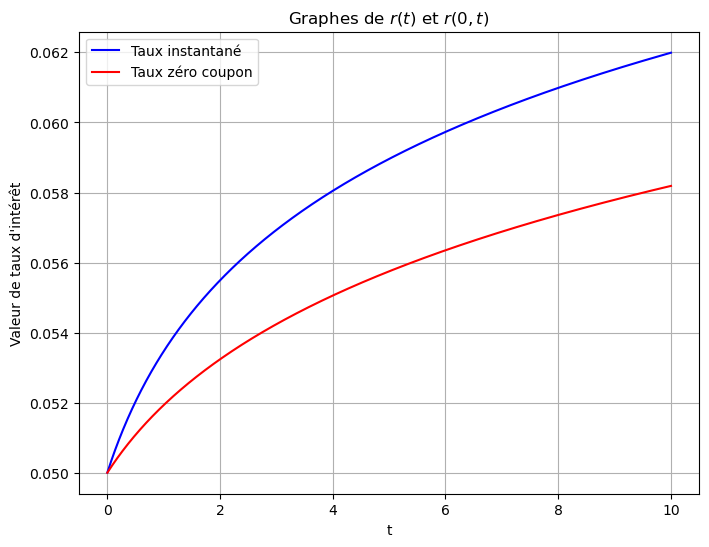

In [21]:
t_values = np.linspace(0.001,10,1000)
plt.figure(figsize=(8, 6)) 
plt.plot(t_values, r_inst(t_values), label='Taux instantané', color='blue') 
plt.plot(t_values, r_zero(t_values), label='Taux zéro coupon', color='red') 
plt.title(fr"Graphes de $r(t)$ et $r(0,t)$")  
plt.xlabel('t')  
plt.ylabel('Valeur de taux d\'intérêt')
plt.grid(True)  
plt.legend()  
plt.show()  

Voici deux routines permettant de calculer le prix d'une obligation. 
* La première `bond_price_with_zero_rate_curve` va utiliser $r(0,t)$ et calculer le prix de l'obligation de la façon suivante : $$B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}\left(-r(0,t_i)t_i\right).$$
* La seconde `bond_price_with_instantaneous_rate_curve` va utiliser $r(t)$ et calculer le prix de l'obligation de la façon suivante : $$B = \displaystyle \sum_{i=1}^n c_i \, \text{exp}\left(-\displaystyle \int_0^{t_i} r(s) \, ds \right).$$ Nous utilierons `simpson_rule` à travers la routine `tolerance_approximation` pour garantir une approximation de qualité avec `tol = 1e-12`. 

Les arguments de ces deux routines sont : 
* `n`, le nombre de flux. 
* `t_cash_flow`, le vecteur des dates auxquelles ont lieux ces flux. 
* `c_cash_flow`, le vecteur des montants versés aux dates initiées par le précédent vecteur. 
* `r_zero` (resp. `r_inst`) le taux zéro-coupon (resp. le taux instantané). 

In [5]:
def bond_price_with_zero_rate_curve(n,t_cash_flow,c_cash_flow,r_zero) : 
    B = 0 
    for i in range (0,n) : 
        discount_factor = np.exp(-t_cash_flow[i]*r_zero(t_cash_flow[i]))
        B += c_cash_flow[i]*discount_factor
    return B 

In [6]:
def bond_price_with_instantaneous_rate_curve(n, t_cash_flow, c_cash_flow, r_inst) : 
    B = 0
    for i in range (0,n) : 
        integral = tolerance_approximation(1e-12, 0, t_cash_flow[i], r_inst, simpson_rule)
        discount_factor = np.exp(-integral[0])
        B += c_cash_flow[i]*discount_factor
    return B

>**Application :** Nous allons calculer le prix d'une obligation à coupon semestriel de maturité deux ans avec un taux de coupon de $5 \%$, et un nominal de $100$.

In [27]:
n = 4    # Nombre de flux. 
C = 0.05 # Taux de coupon.
F = 100  # Nominal. 
c_cash_flow = [C/2*F] * (n-1) + [(1 + C/2)*F] # = [2.5, 2.5, 2.5, 102.5] après calculs.
t_cash_flow = [1/2, 1, 3/2, 2]

start_time = time.time()
print("En utilisant la courbe de taux zéro-coupon : B = ", bond_price_with_zero_rate_curve(n,t_cash_flow,c_cash_flow,r_zero))
end_time = time.time()
execution_time = end_time - start_time
print("Éxécuté en : ", execution_time, "secondes.")

start_time2 = time.time()
print("En utilisant la courbe de taux instantanés : B = ", bond_price_with_instantaneous_rate_curve(n, t_cash_flow, c_cash_flow, r_inst))
end_time2 = time.time()
execution_time2 = end_time2 - start_time2 
print("Éxécuté en : ", execution_time2, "secondes.")

En utilisant la courbe de taux zéro-coupon : B =  99.26750830935971
Éxécuté en :  0.0003199577331542969 secondes.
En utilisant la courbe de taux instantanés : B =  99.26750830936105
Éxécuté en :  0.004029989242553711 secondes.


>**Remarque:** La routine `bond_price_with_zero_rate_curve` est plus efficiente est ceci était en effet prévisible. Elle ne nécéssite pas de faire appel à une approximation d'une intégrale, qui lorsque le seuil de tolérance est fin, peut être (très) coûteux. 

Implémentons la routine `price_duration_convexity` permettant de calculer à la fois le prix de l'obligation, sa duration ainsi que sa convexité, étant donné : 
* `n`, le nombre de flux. 
* `t_cash_flow`, le vecteur des dates auxquelles ont lieux ces flux. 
* `c_cash_flow`, le vecteur des montants versés aux dates initiées par le précédent vecteur. 
* `y`, le taux actuariel de l'obligation. 

Nous aurons besoin des formules suivantes : 

$$ B = \displaystyle \sum_{i=1}^n c_i\,\text{exp}(-yt_i),\, D = \dfrac{1}{B} \sum_{i=1}^n t_ic_i \, \text{exp}(-yt_i), \,C = \dfrac{1}{B}\displaystyle\sum_{i=1}^n t_i^2c_i\,\text{exp}(-yt_i).$$

In [28]:
def price_duration_convexity(n,t_cash_flow, v_cash_flow, y) : 
    B = 0
    D = 0
    C = 0
    for i in range (0,n) : 
        discount_factor = np.exp(-t_cash_flow[i]*y)
        B += v_cash_flow[i]*discount_factor
        D += t_cash_flow[i]*v_cash_flow[i]*discount_factor
        C += t_cash_flow[i]**2*v_cash_flow[i]*discount_factor 
    D /= B 
    C /= B
    return B,D,C

>**Application :** Calculons le prix, la duration et la convexité d'une obligation bi-anuelle, de taux de coupon $6\%$, de maturité 30 mois, de taux actuariel $9\%$. 


In [29]:
n = 5
C = 0.06
y = 0.09
F = 100
t_cash_flow = [6/12, 12/12, 18/12, 24/12, 30/12]
c_cash_flow = [C/2*F] * (n-1) + [(1 + C/2)*F] # = [3.0, 3.0, 3.0, 3.0, 103.0] après calculs.
print('B = ', price_duration_convexity(n,t_cash_flow, c_cash_flow, y)[0])
print('D = ', price_duration_convexity(n,t_cash_flow, c_cash_flow, y)[1])
print('C = ', price_duration_convexity(n,t_cash_flow, c_cash_flow, y)[2])

B =  92.98391490282674
D =  2.3524182565205916
C =  5.736738800380953
